# Getting Started

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw4'

In [2]:
# install latest version deepul package
# !pip install -e .

In [3]:
from deepul.hw4_helper import *
import warnings
import torch
from tqdm import tqdm
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from deepul.hw4_helper import q1_save_results
from models.Diffusion1 import Diffusion1

warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

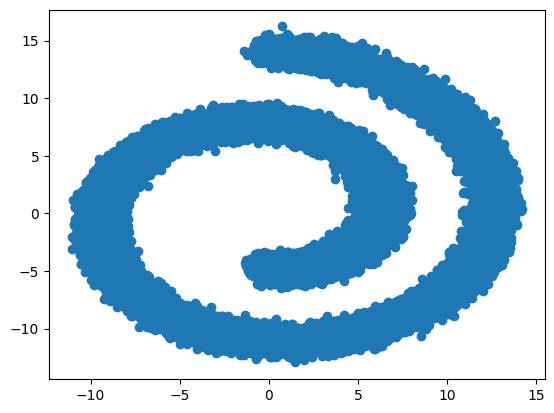

In [4]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [5]:

def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """
    train_losses = []
    test_losses = []
    batch_size = 1024
    max_epochs = 100
    learning_rate = 1e-3
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Diffusion1().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_mean = torch.tensor(train_data.mean(axis=0)).to(device)
    train_std = torch.tensor(train_data.std(axis=0)).to(device)

    def normalize_transform(data):
        return (data - train_mean) / train_std

    def denormalize_transform(data):
        return (data * train_std) + train_mean

    train_dataset = TensorDataset(torch.from_numpy(train_data).float())
    test_dataset = TensorDataset(torch.from_numpy(test_data).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    for epoch in tqdm(range(max_epochs)):
        for [batch_x] in train_loader:
            optimizer.zero_grad()
            batch_x = normalize_transform(batch_x.to(device))
            t, x_t, epsilon = model.generate_noise_steps(batch_x, device=device)
            epsilon_hat = model.forward(x_t, t)
            loss = model.loss_function(epsilon_hat, epsilon)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            test_batch_losses = []
            for [batch_x] in test_loader:
                batch_x = normalize_transform(batch_x.to(device))
                t, x_t, epsilon = model.generate_noise_steps(batch_x, device=device)
                epsilon_hat = model.forward(x_t, t)
                loss = model.loss_function(epsilon_hat, epsilon)
                test_batch_losses.append(loss.item())
            test_losses.append(np.array(test_batch_losses).mean().item())
        model.train()
    all_samples = []
    for num_steps in np.power(2, np.linspace(0, 9, 9)).astype(int):
        samples = denormalize_transform(model.generate(2000, num_steps, device)).numpy(force=True)
        all_samples.append(samples)
    all_samples = np.array(all_samples)
    return train_losses, test_losses, all_samples

100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Final Test Loss: 0.4263


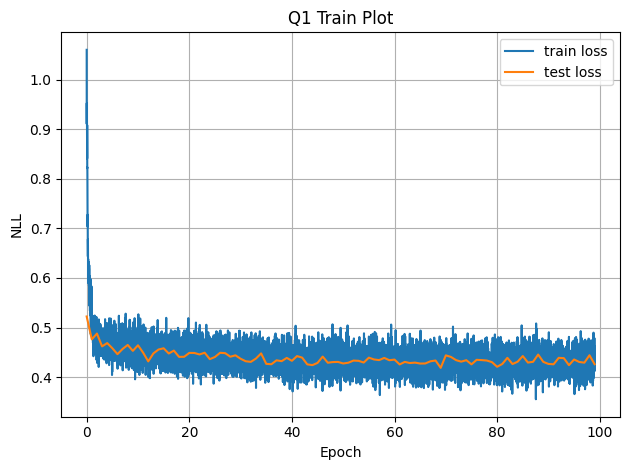

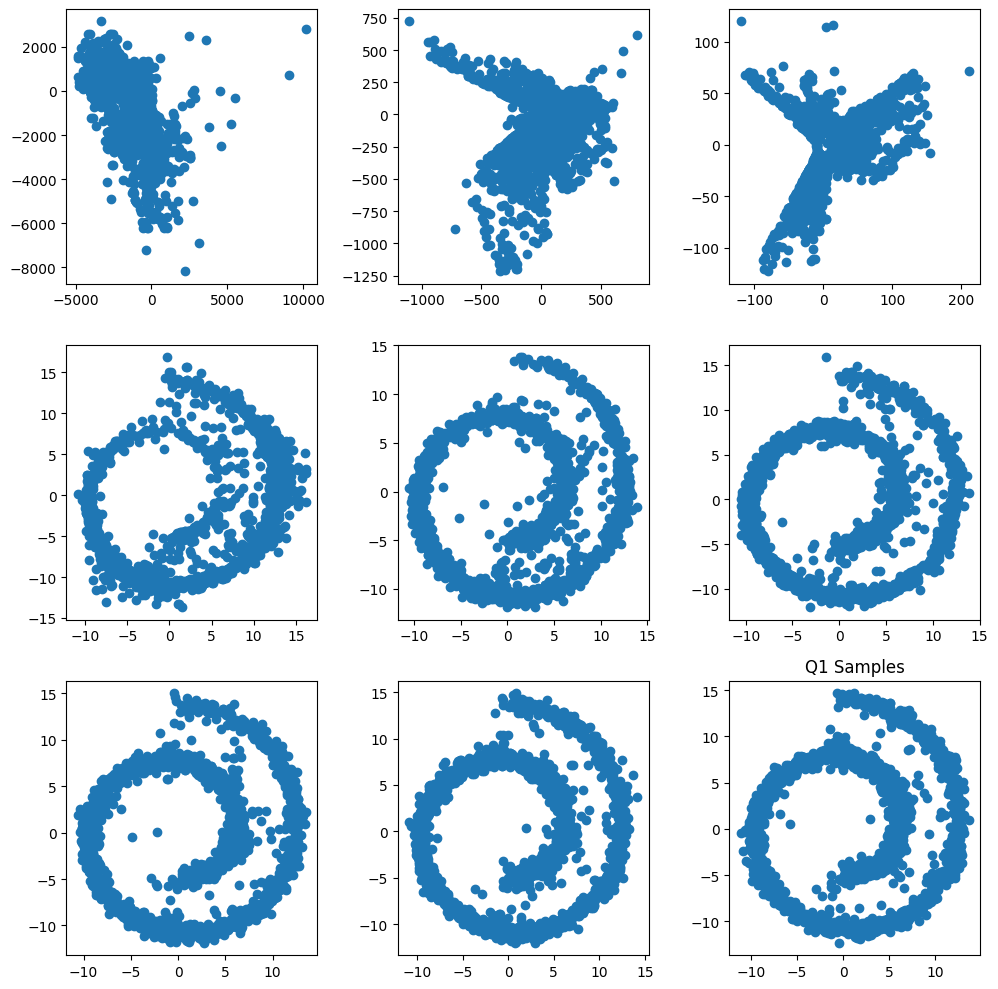

In [6]:
q1_save_results(q1)